In [1]:
import sys
import math
import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 1. Add parent directory to path
sys.path.append(str(Path("..").resolve()))

# 2. Import modularized code
from hyper_rbm import load_model

# Define paths
models_dir = Path("models")
# Set device (Auto-detect or force CPU if preferred for this specific task)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Running on: {device}")
print(f"Looking for models in: {models_dir.resolve()}")

Running on: cpu
Looking for models in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_4x4_mod/models


In [2]:
def estimate_susceptibility_mc(model, h_val, n_samples):
    dtype = next(model.parameters()).dtype
    rng = torch.Generator(device=device).manual_seed(42)

    with torch.no_grad():
        # ADAPTATION: generate() infers batch size from cond_batch.
        cond_batch_gen = torch.full((n_samples, 1), h_val, device=device, dtype=dtype)

        # Create a constant T=1.0 schedule of length model.k
        schedule_tensor = torch.tensor([1.0] * model.k, device=device, dtype=dtype)

        # New signature: generate(cond, T_schedule, rng)
        samples = model.generate(cond_batch_gen, T_schedule=schedule_tensor, rng=rng)

    # Create a batch of conditioning values for later gradient computation
    cond_batch_grad = torch.full((n_samples, 1), h_val, device=device, dtype=dtype, requires_grad=True)

    # We evaluate log_score with gradients enabled on cond_batch
    # Note: samples do not require grad, only cond_batch_grad does
    log_psi = model.log_score(samples, cond_batch_grad)

    # Compute gradients (Jacobian diagonal)
    grads = torch.autograd.grad(
        outputs=log_psi,
        inputs=cond_batch_grad,
        grad_outputs=torch.ones_like(log_psi), # upstream gradient
        create_graph=False
    )[0]

    # Chi_F is the variance of the gradient of log_psi
    chi = torch.var(grads.squeeze(), unbiased=True)
    return chi.item()

In [3]:
# Update this filename to the one you just generated
model_filename = "hyprbm_tfim_4x4_20000_suscept_20260118_193026.pt"
model_path = models_dir / model_filename

print(f"Loading checkpoint: {model_path.name}")

# load_model handles architecture initialization internally
model, config = load_model(model_path, device)

# Extract metadata
h_support = config.get("h_support", [])
GEN_SIDE_LENGTH = int(math.sqrt(model.num_v)) # Changed num_visible -> num_v

print(f"Model Loaded. System Size: {GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}")
print(f"Training Support Points: {h_support}")

Loading checkpoint: hyprbm_tfim_4x4_20000_suscept_20260118_193026.pt
Model Loaded. System Size: 4x4
Training Support Points: [1.0, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]


In [4]:
h_min = 1.0
h_max = 5.0
num_steps = 70
h_eval = np.linspace(h_min, h_max, num_steps)
gibbs_samples = 30_000

print(f"Estimating Susceptibility (MC) on {num_steps} points...")

chi_values = []

for h in h_eval:
    chi = estimate_susceptibility_mc(model, h, n_samples=gibbs_samples)
    chi_values.append(chi)

    if (len(chi_values) % 10) == 0:
        print(f"h={h:.2f} | chi={chi:.4f}")

print("Sweep Complete.")

Estimating Susceptibility (MC) on 70 points...
h=1.52 | chi=0.3305
h=2.10 | chi=0.5202
h=2.68 | chi=0.6994
h=3.26 | chi=0.2173
h=3.84 | chi=0.0449
h=4.42 | chi=0.0142
h=5.00 | chi=0.0078
Sweep Complete.


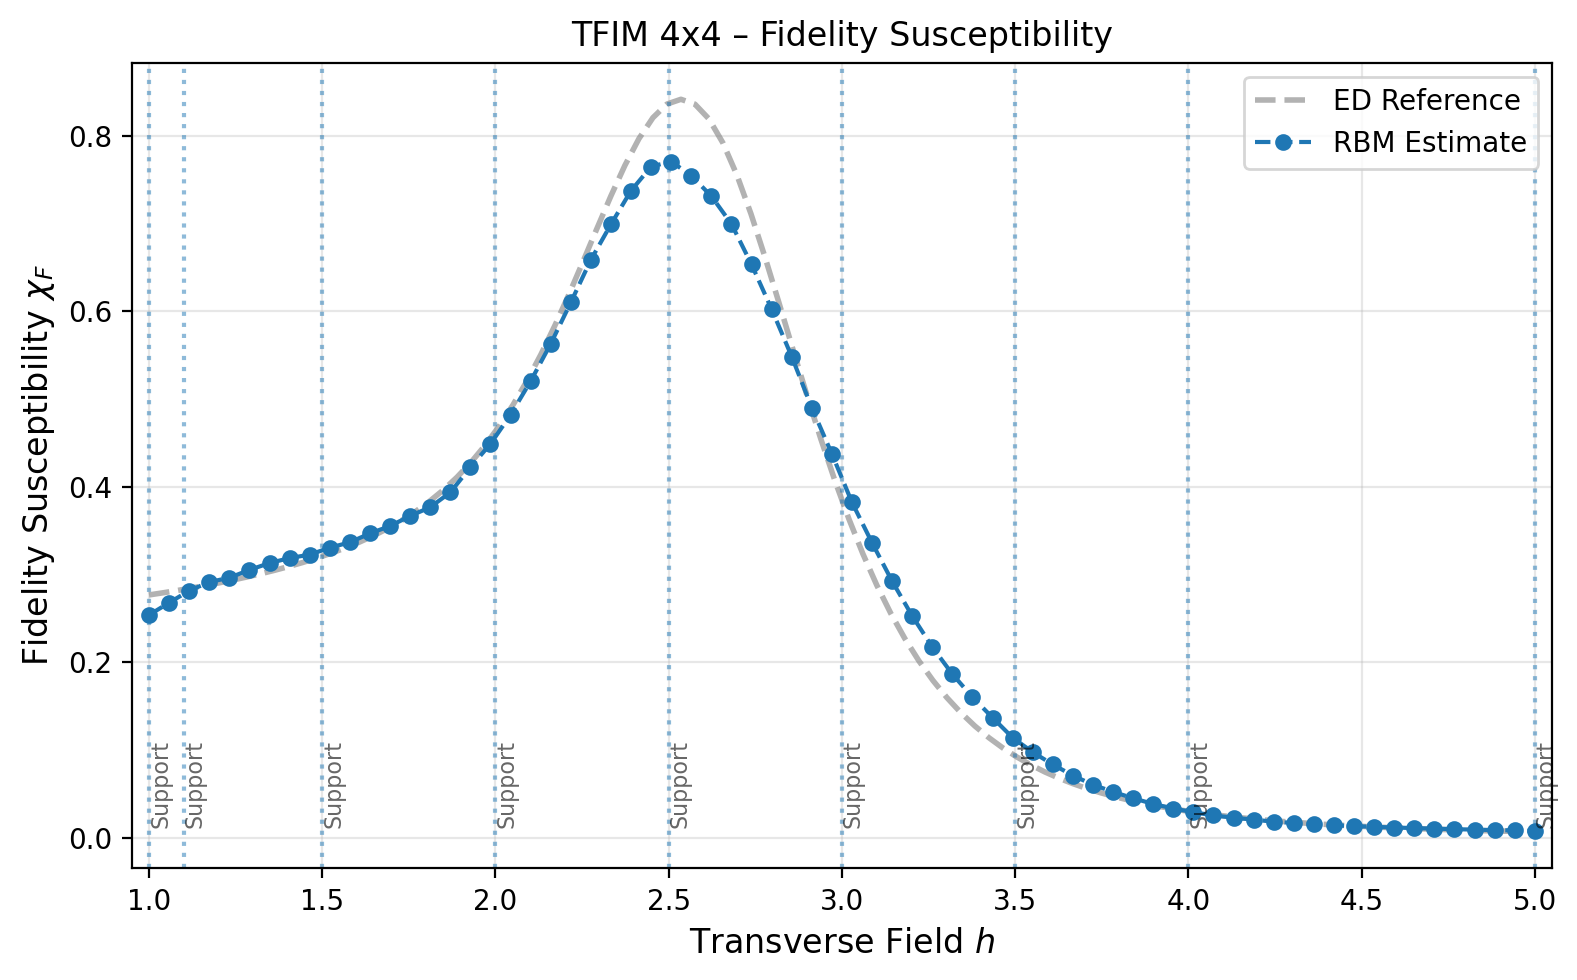

In [5]:
# Load reference data if available
ref_file = Path("tfim_4x4_suscept_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

XLIM = (0.95, 5.05)
SUPPORT_LABEL_YOFFSET = 0.05

plt.figure(figsize=(8,5), dpi=200)

if ref_df is not None:
    plt.plot(ref_df["h"].values, ref_df["chi_F"].values, "--", alpha=0.6, color="gray",
             linewidth=2, label="ED Reference")

plt.plot(h_eval, chi_values, "o--", markersize=5, label="RBM Estimate")

# Plot support markers
ymin, ymax = plt.ylim()
for h_supp in h_support:
    if XLIM[0] <= h_supp <= XLIM[1]:
        plt.axvline(h_supp, linestyle=":", alpha=0.5)
        plt.text(h_supp, ymin + SUPPORT_LABEL_YOFFSET * (ymax - ymin), "Support",
                 rotation=90, va="bottom", fontsize=8, alpha=0.6)

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility $\chi_F$", fontsize=12)
plt.title(f"TFIM {GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH} – Fidelity Susceptibility", fontsize=12)

plt.xlim(*XLIM)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
data = np.column_stack((h_eval, chi_values))

file_name = f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_suscept_rbm_{timestamp}.csv"
header = "h,chi_F"

np.savetxt(file_name, data, delimiter=",", header=header, comments="")
print(f"Data saved to: {file_name}")

Data saved to: tfim_4x4_suscept_rbm_20260118_193148.csv
